In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pandas.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


adfuller : p=0.991850


<Figure size 720x720 with 0 Axes>

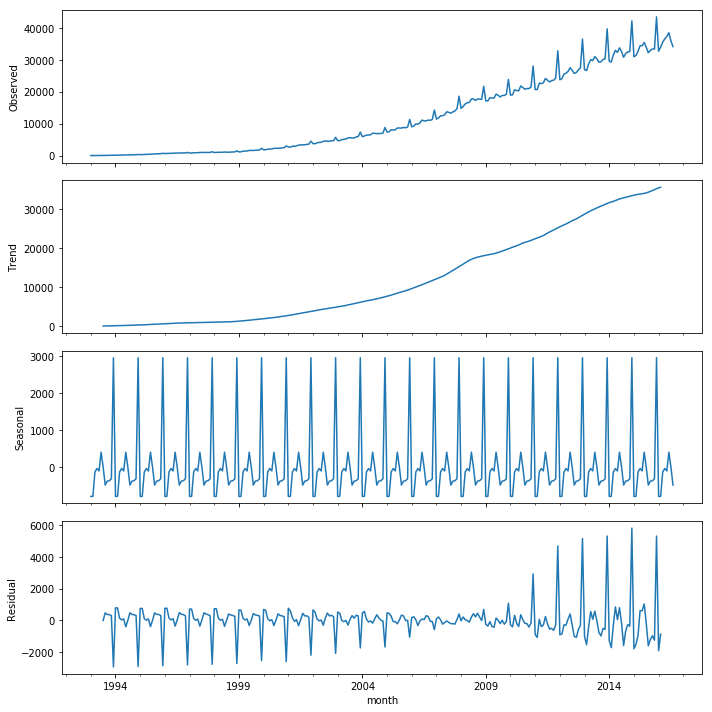

In [3]:
# Визуальный анализ ряда
plt.figure(figsize(10,10))
sm.tsa.seasonal_decompose(data['WAG_C_M']).plot()
print "adfuller : p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M'])[1]
# тренд и нестационарен

In [4]:
# график имеет тренд и нестационарен.

boxcox lmbda: 0.263202
adfuller : p=0.696899


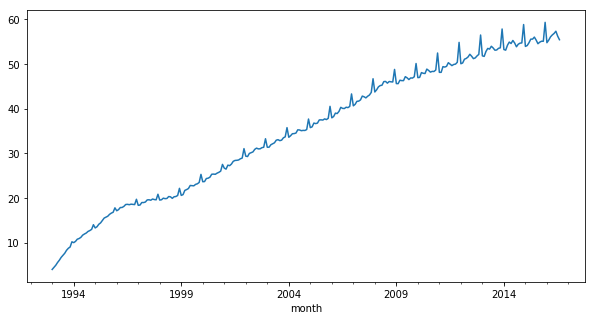

In [5]:
# Стабилизация дисперсии
# apply boxcox
data['boxcox'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(10,5))
data.boxcox.plot()
#plt.ylabel(u'Transformed ZP')
print "boxcox lmbda: %f" % lmbda
print "adfuller : p=%f" % sm.tsa.stattools.adfuller(data.boxcox)[1]
# Все еще ряд не стал стационарен

adfuller: p=0.014697


<Figure size 720x720 with 0 Axes>

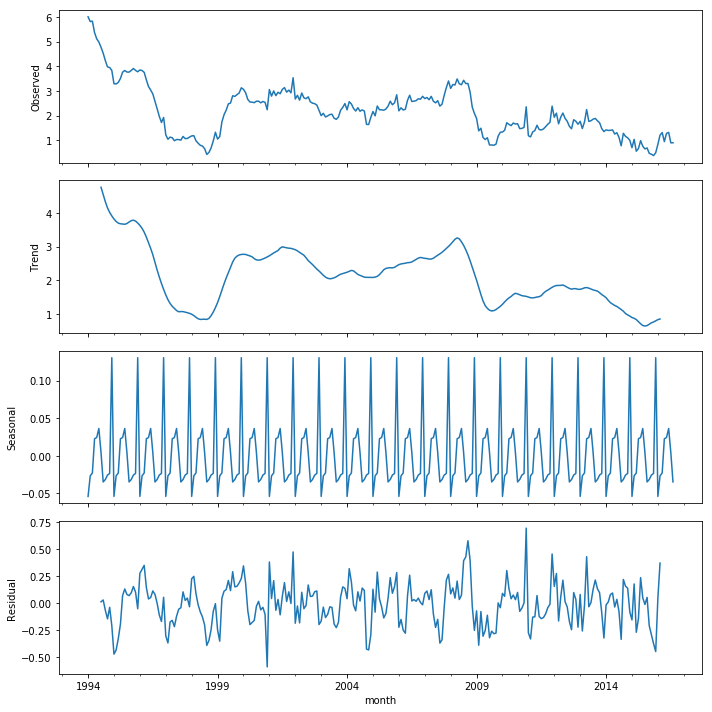

In [8]:
# Выбор порядка дифференцирования
lag12=12
data['diff_12'] = data.boxcox - data.boxcox.shift(lag12)
plt.figure(figsize(10,10))
sm.tsa.seasonal_decompose(data.diff_12[lag12:]).plot()
print "adfuller: p=%f" % sm.tsa.stattools.adfuller(data.diff_12[lag12:])[1]

adfuller: p=0.000000


<Figure size 1080x720 with 0 Axes>

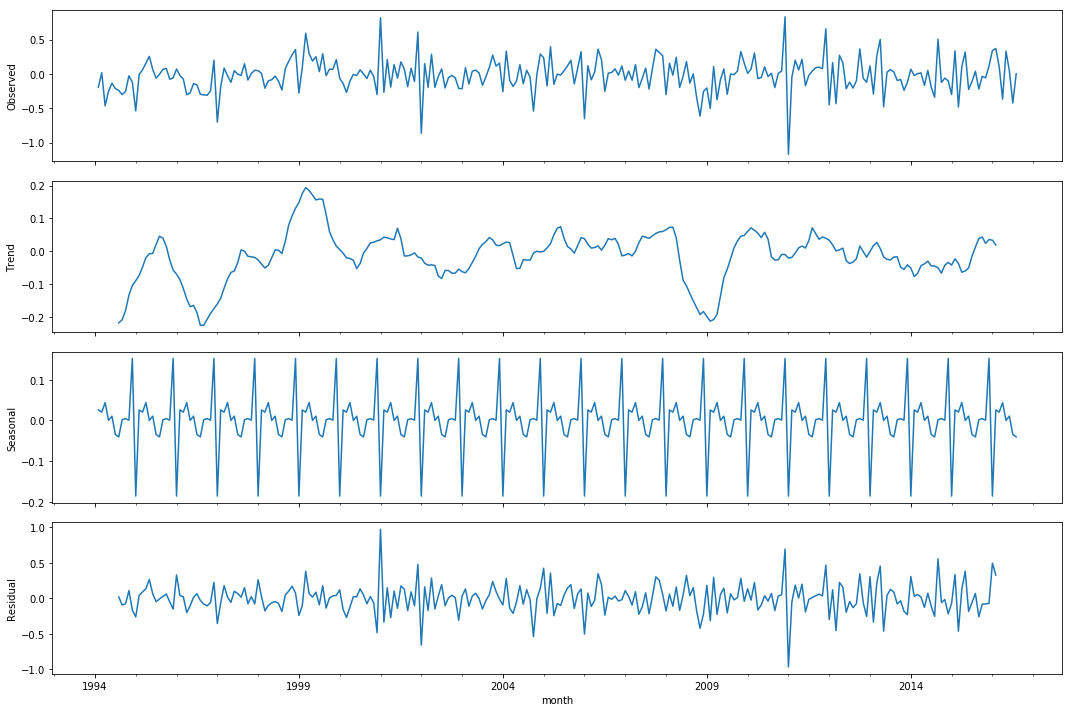

In [9]:
# Выбор порядка дифференцирования
lag1 = 1
data['diff_12_1'] = data.diff_12 - data.diff_12.shift(lag1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.diff_12_1[lag12+lag1:]).plot()
print "adfuller: p=%f" % sm.tsa.stattools.adfuller(data.diff_12_1[lag12+lag1:])[1]

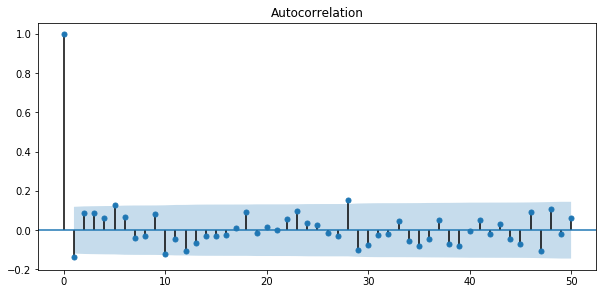

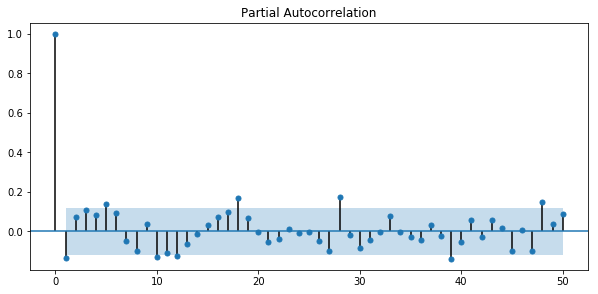

In [10]:
# Выбор начальных приближений для p,q,P,Qp, q, P, Qp,q,P,Q
plt.figure(figsize(10,10))
sm.graphics.tsa.plot_acf(data.diff_12_1[lag12+lag1:].values.squeeze(), lags=50, ax=plt.subplot(211))
pylab.show()
sm.graphics.tsa.plot_pacf(data.diff_12_1[lag12+lag1:].values.squeeze(), lags=50, ax=plt.subplot(212))
pylab.show()

In [11]:
#Выбор начальных приближений для p,q,P,Q
d=1 
D=1

In [12]:
# Обучение и сравнение моделей-кандидатов, выбор победителя
warnings.filterwarnings('ignore')
min_aic = float("inf")
for p in range(0, 2):
    for P in range(0, 2):
        for q in range(0, 2):
            for Q in range(0, 2):
                try:
                    arima=sm.tsa.statespace.SARIMAX(data.boxcox, order=(p, d, q), seasonal_order=(P, D, Q, lag12)).fit(disp=-1)
                except ValueError:
                    continue
                    
                if arima.aic < min_aic:
                    best_arima = arima
                    min_aic = arima.aic
                    best_pqPQ = [p, q, P, Q]

In [13]:
print best_pqPQ
print min_aic
print best_arima.summary()

[1, 0, 1, 0]
0.34052093719553156
                                 Statespace Model Results                                 
Dep. Variable:                             boxcox   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Wed, 24 Oct 2018   AIC                              0.341
Time:                                    23:21:28   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar

In [14]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

ttest_1samp: p=0.090793
adfuller: p=0.000003


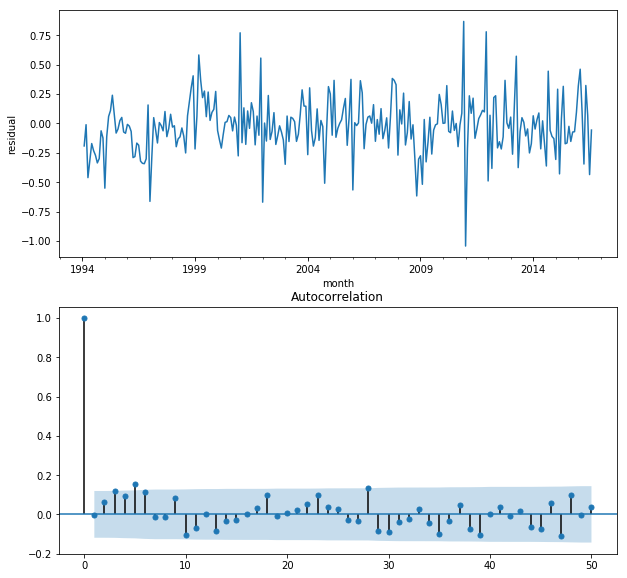

In [15]:
# Анализ остатков построенной модели
plt.figure(figsize(10,10))
plt.subplot(211)
best_arima.resid[13:].plot()
plt.ylabel('residual')

sm.graphics.tsa.plot_acf(best_arima.resid[lag12+lag1:].values.squeeze(), lags=50, ax=plt.subplot(212))

print "ttest_1samp: p=%f" % stats.ttest_1samp(best_arima.resid[lag12+lag1:], 0)[1]
print "adfuller: p=%f" % sm.tsa.stattools.adfuller(best_arima.resid[13:])[1]

# Остатки несмещены (ttest_1samp) стационарны (adfuller) 

In [ ]:
# Анализ остатков построенной модели
data['model'] = invboxcox(best_arima.fittedvalues, lmbda)
plt.figure(figsize(10,5))
data.WAG_C_M.plot(color='b')
data.model[lag12+lag1:].plot(color='r')
pylab.show()

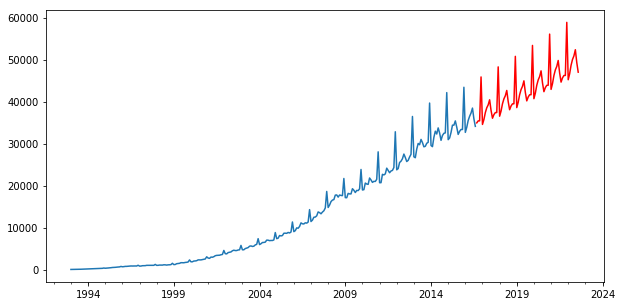

In [17]:
# Прогнозирование с помощью финальной модели.
data_all = data[['WAG_C_M']]
future = pandas.DataFrame(index=[datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,72)], columns= data_all.columns)
data_all = pandas.concat([data_all, future])
data_all['predict'] = invboxcox(best_arima.predict(start=data.shape[0], end=data.shape[0] + 128), lmbda)

plt.figure(figsize(10,5))
data_all.WAG_C_M.plot()
data_all.predict.plot(color='r')
pylab.show()
